# 10. 재발사건 생존분석
#### 재발사건 : 추적기간동안 동일한 유형의 사건이 한 번 이상 발생
#### 재바살사건 생존분석 (recurrent event survival analysis) : 관련있는 변수들과 재발사건 발생률의 관계를 연구

In [2]:
library(tidyverse)
library(autoReg)
library(survival)

# 
### 10-1 계수과정접근 (counting process, CP) 
#### 각 재발사건들이 동일하다고 가정하고 분석

# 
#### 표1 : 2개의 치료법에 대한, 가상의 환자 2명
- A는 치료 1을 받고, 3개월, 9개월, 21개월에 암이 재발. 23개월에는 재발 X. 23개월 이후에는 추적 X
- B는 치료 0을 받고, 3개월, 15개월, 25개월에 재발하였고, 25개월에 추적탈락
# 

| 환자 | Time interval | Event Indicator | Treatment Group |
| - | - | - | - |
| A | 0 to 3 | 1 | 1| 
| | 3 to 9 | 1 | 1 | 
| | 9 to 21 | 1 | 1|
| | 21 to 23 | 0 | 1 |
| B | 0 to 3 | 1 | 0 |
| | 3 to 15 | 1 | 0 |
| | 15 to 25 | 1 | 0 |

# 
#### 표2 : 환자 위주의 데이터 형식 
# 

| | A | B |
| - | - | - |
| 재발사건 수 | 3 | 3 |
| 추적기간 | 23개월 | 25개월 |
| 추적시작부터 재발까지 시간 | 3, 9, 21 | 3, 15, 25 |
| 마지막 재발 후 추적기간 | 2개월 | 0개월 |

# 
#### 표3 : 통계처리를 위한 데이터 형식
# 

| subject | interval Number | Time Start | Time Stop | Event status | Treatment Group |
| - | - | - | - | - | - |
| A | 1 | 0 | 3 | 1 | 1 |
| A | 2 | 3 | 9 | 1 | 1 |
| A | 3 | 9 | 23 | 1 | 1 |
| A | 4 | 21 | 23 | 0 | 1 |
| B | 1 | 0 | 3 | 1 | 0 |
| B | 2 | 3 | 5 | 1 | 0 |
| B | 3 | 15 | 25 | 1 | 0 |

# 
# 
### 10-2 계수과정모형과 방법
- 계수과정접근으로 하는 생존분석은 표준적인 콕스비례위험모형이므로, 보통의 비례위험모형과 마찬가지로 **비례위험 가정에 합당한지 평가가 필요**
- **비례위험 가정에 합당하지 않은 경우, 층화된 콕스모형을 사용하거나, 시간 의존 공변량이 있는 경우에는 확장된 콕스모형의 사용을 고려**

# 
#### 재발사건을 다루지 않는 콕스모형과의 차이
| 재발사건 데이터 | 재발사건이 없는 데이터 |
| - | - |
| 1개 이상의 재발사건을 갖는 대상환자는 마지막 재발 사건이 끝날 때까지 위험대상에서 제거되지 않음 | 실패나 중도절단된 대상환자는 위험대상에서 제외 |
| 데이터의 각 행은 같은 환자의 자료라도 서로 독립적인 것으로 취급 | 데이터의 각 행은 서로 다른 환자의 자료이므로, 서로 독립적 |

# 
#### 실패시간 순서에 따른 위험대상
- 위험대상환자 $n_1 = 20$
- 첫 달에 17번 환자가 재발 (failed)
- 1번 환자는 중도탈락(censored)
- **1번 환자는 이후 기록이 없으므로, 두 번째 달의 위험대상환자에서 제외됬으나, 17번 환자는 두 번째 재발사건의 기록이 있으므로, 제외되지 않음 => $n_2 = 19$**
# 


| Ordered failure time ($t_f$)  | at risk ($n_f$) | failed  ($m_f$) | Censored in $[t_f, t_{f+1}]$ ($q_f$) | Subject ID's for outcomes in $[t_f, t_{f+1}]$ (id) | 
| - | - | - | - | - | 
| 1 | 20 | 1 | 1 | 1, 17 | 
| 2 | 19 | 1 | 0 | 18 | 
| 3 | 19 | 3 | 1 | 2, 12, 13, 15 | 
| 5 | 18 | 1 | 1 | 8 | 
| 6 | 18 | 1 | 0 | 5 | 
| 7 | 18| 1 | 1 | 3, 14 | 
| 9 | 17 | 1 | 0 | 13 | 
| 10 | 17 | 2 | 0 | 4, 5, 11, 14 | 
| 12| 15 | 1 | 1 | 6, 9 | 
| 15 | 14 | 2 | 0 | 11, 15 | 
| 16 | 14 | 3 | 2 | 7, 8, 9, 12, 14 | 
| 21 | 11 | 1 | 1 | 13 | 
| 23 | 11 | 1 | 3 | 10, 11, 12, 13 | 
| 24 | 7 | 1 | 0 | 14 | 
| 25 | 6 | 2 | 0 | 15, 19 | 
| 26 | 5 | 1 | 4 | 16, 17, 18, 19, 20 | 

# 
#### 공변량이 $rx, number, size$3개 일 때, 콕스비례위험모형의 위험함수
### $h(t, X) = h_0 (t) exp(\beta_1 rx + \beta_2 number + \beta_3 size)$

# 
#### 어떤 대상환자가 10개월째에 추적에서 탈락되었다가, 25개월째에 다시 위험대상에 합류하는 경우 => 10개월부터 25개월까지 단절
- 부분가능도함수($L$)는 각각의 실패시간의 가능도의 곱 (**총 16개의 실패시간이 있는 것으로 간주**)

### $L = L_1 \times L_3 \times ... \times L_{16}$

 

- **$t_f$ (f번째 실패시간)의 부분가능도 $L_f$는,  $t_f$까지 살아 있다는 조건하에 $t_f$에서 실패할 조건부확률**
    - j번째 실패시간에 1명의 대상에서 실패가 일어났다면, $L_f$는 다음과 같이 표현
    
### $L_f = {{exp(\beta_1 rx_f + \beta_2 number_f + \beta_3 size_f)}\over{\sum_{s in R(t_f)} exp(\beta_1 rx_{s_f} + \beta_2 number_{s_f} + \beta_3 size_{s_f})}}$

# 
- $rx_f, number_f, size_f$는 실패시간 $t_f$에서 실패한 대상의 예측변수 값
- s는 실패시간 $t_f$에서의 위험대상환자
- $rx_f, number_f, size_f$는 그 대상환자들의 예측변수 값

# 
#### 예 :
- 14번 대상환자는 모두 4번의 재발을 경험
- 그 중 4번째인 24개월째에 위험대상환자 $R(= at\;risk)$은 모두 7명 ($subject\;s_{14} = \{14, 15, 16, 17, 18, 19, 20\}$)
- 이 때의 가능도 $L_14$

### $L_14 = {{exp(\beta_1 (1) + \beta_2(2) + \beta_3 (3))}\over{\sum_{s\;in\;R(t_{14})} exp(\beta_1 rx_{s_{14}} + \beta_2 number_{s_{14}} + \beta_3 size_{s_{14}})}}$

In [18]:
bladder2 %>% filter(id == 14)

id,rx,number,size,start,stop,event,enum
<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
14,1,2,3,0,7,1,1
14,1,2,3,7,10,1,2
14,1,2,3,10,16,1,3
14,1,2,3,16,24,1,4


# 
# 
### 10-4 로버스트 추정
#### 13번째 환자의 데이터
- 13번 환자의 4행 자료들은, 1명의 환자에게 기록된 자료이지만, **콕스모형에서 분석할 때는 모두 돌깁된 사건으로 취급**
- **같은 대상환자에게서 나온 연관성 높은 자료들을 보정하기 위해 사용되는 방법 : 로버스트 추정 (robust estimation, 경험적 추정)**

In [17]:
bladder2 %>% filter(id == 13)

id,rx,number,size,start,stop,event,enum
<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
13,1,3,1,0,3,1,1
13,1,3,1,3,9,1,2
13,1,3,1,9,21,1,3
13,1,3,1,21,23,0,4


# 
#### 로버스트추정은 적합된 모형의 회귀계수 추정분산을 보정
- **모형의 회귀계수는 보정하지 않으며, 추정된 분산만을 보정** 
- 같은 환자로부터 나온 연관 데이터로 만든 모형의 가설검정과 신뢰구간 추정이 가능
- **재발사건의 회귀계수 분산을 로버스트 방식으로 추정하려면, 적합된 콕스모형의 최대가능도 추정으로 얻은 분산과 공분산의 정보행렬의 행렬식으로 계산**

### $\hat{R}(\hat{\beta}) = \hat{Var}(\hat{\beta}) [\hat{R_s '}\hat{R_s}]\hat{Var}(\hat{\beta})$

($\hat{Var}(\hat{\beta})$ = 정보행렬, $\hat{R}_s$ = 스코어잔차 행렬)

# 
# 
### 10-5 계수과정접근법의 결과

In [13]:
fit = coxph(Surv(start, stop, event) ~ rx + number + size, bladder2)
summary(fit)

Call:
coxph(formula = Surv(start, stop, event) ~ rx + number + size, 
    data = bladder2)

  n= 178, number of events= 112 

           coef exp(coef) se(coef)      z Pr(>|z|)    
rx     -0.46469   0.62833  0.19973 -2.327 0.019989 *  
number  0.17496   1.19120  0.04707  3.717 0.000202 ***
size   -0.04366   0.95728  0.06905 -0.632 0.527196    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

       exp(coef) exp(-coef) lower .95 upper .95
rx        0.6283     1.5915    0.4248    0.9294
number    1.1912     0.8395    1.0862    1.3063
size      0.9573     1.0446    0.8361    1.0960

Concordance= 0.634  (se = 0.032 )
Likelihood ratio test= 17.52  on 3 df,   p=6e-04
Wald test            = 19.11  on 3 df,   p=3e-04
Score (logrank) test = 19.52  on 3 df,   p=2e-04


# 
#### ```cluster()``` : 로버스트 추정
- ```rx```에 대한 회귀계수 : -0.46469 / 표준오차 : 0.19973
- 로버스트 표준오차 : 0.26556

In [21]:
fit1 = coxph(Surv(start, stop, event) ~ rx + number + size + cluster(id), bladder2)
summary(fit1)

Call:
coxph(formula = Surv(start, stop, event) ~ rx + number + size, 
    data = bladder2, cluster = id)

  n= 178, number of events= 112 

           coef exp(coef) se(coef) robust se      z Pr(>|z|)   
rx     -0.46469   0.62833  0.19973   0.26556 -1.750  0.08015 . 
number  0.17496   1.19120  0.04707   0.06304  2.775  0.00551 **
size   -0.04366   0.95728  0.06905   0.07762 -0.563  0.57376   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

       exp(coef) exp(-coef) lower .95 upper .95
rx        0.6283     1.5915    0.3734     1.057
number    1.1912     0.8395    1.0527     1.348
size      0.9573     1.0446    0.8222     1.115

Concordance= 0.634  (se = 0.032 )
Likelihood ratio test= 17.52  on 3 df,   p=6e-04
Wald test            = 11.54  on 3 df,   p=0.009
Score (logrank) test = 19.52  on 3 df,   p=2e-04,   Robust = 11.27  p=0.01

  (Note: the likelihood ratio and score tests assume independence of
     observations within a cluster, the Wald and robust score test

- Wald 검정을 위한 z통계량은 회귀계수를 로버스트 표준오차로 나눔

In [22]:
-0.46469 / 0.26556

[1] -1.749849

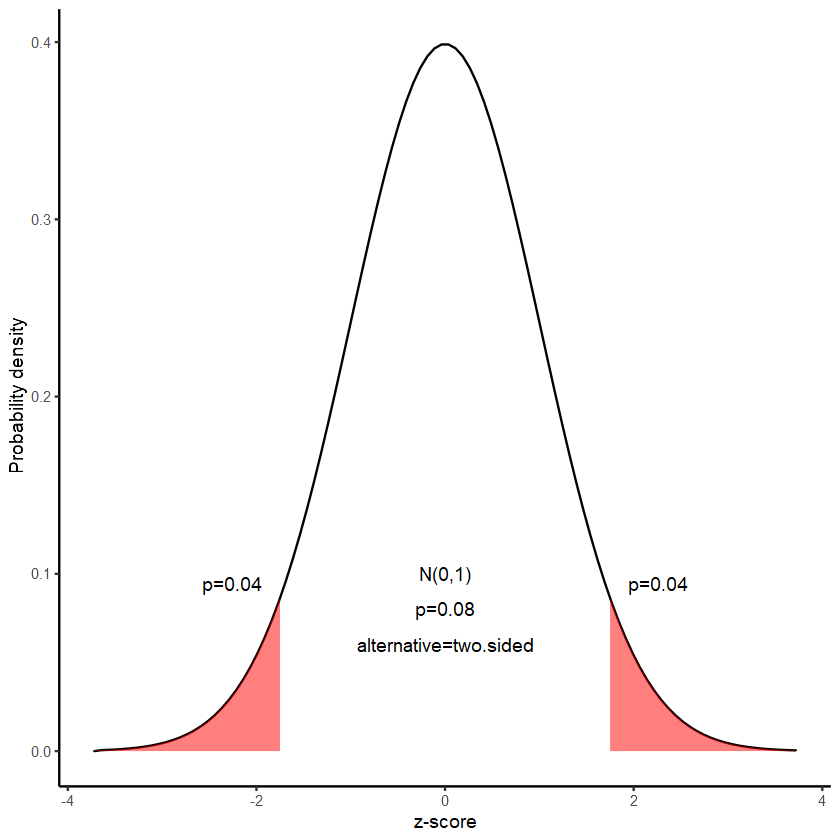

In [33]:
interpretCI::draw_n(z = -1.749849)

In [35]:
pnorm(-abs(-1.749849))*2

[1] 0.08014437

- ```rx```에 대한 위험비(hazard ratio)는 회귀계수로부터 구함

#### $HR = exp(-0.46469) = 0.62833$ => 38%의 위험을 감소

In [37]:
gaze(fit1) %>% myft()

a flextable object.
col_keys: ` `, `coef`, `se(coef)`, `robust se`, `z`, `Pr(>|z|)`, `HR`, `lower`, `upper` 
header has 1 row(s) 
body has 3 row(s) 
original dataset sample: 
—————————————————————————————————————————————————————————————————————————————
            coef  se(coef)  robust se        z  Pr(>|z|)     HR  lower  upper 
—————————————————————————————————————————————————————————————————————————————
rx        -0.465     0.200      0.266  <-1.751     0.080  0.628  0.373  1.057 
number     0.175     0.047      0.063    2.775     0.006  1.191  1.053  1.348 
size      -0.044     0.069      0.078  <-0.563     0.574  0.957  0.822  1.115 
—————————————————————————————————————————————————————————————————————————————
n=178, events=112, Likelihood ratio test=17.52 on 3 df (p<.001) 

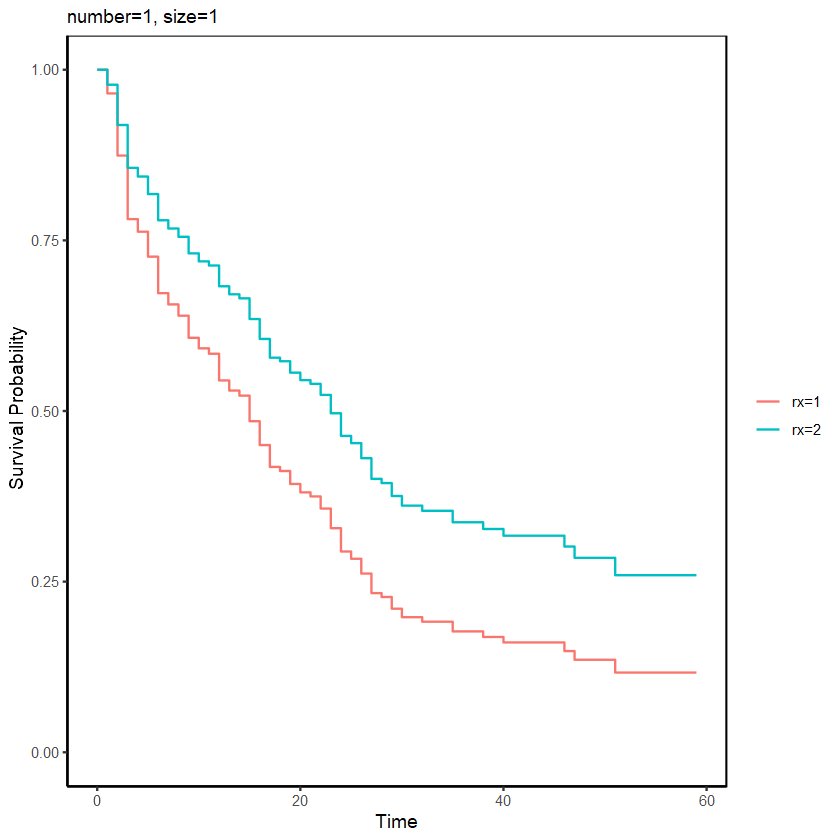

In [38]:
adjustedPlot(fit1, xnames = "rx")

# 
# 
### 10-6 층화된 콕스모형 접근
#### 층화된 콕스모형 (Stratified Cox, SC)는 재발사건이 일어난 순서를 구분
1. **층화된 계수과정 (Stratified Counting Process)**
2. **소요시간 (gap time)**
3. **주변 (marginal)**

#### 3가지 방법 모두 재발사건의 발생순서 (interval number)를 범주형변수로 바꾸어 층화변수(strata variable)로 사용

# 
#### 자료의 형식 
- **층화된 계수과정과 소요시간방법은 모두 재발사건 사이의 생존시간에 초점을 맞춤**
    - 층화된 계수과정에서는 연구에 등록된 시간부터 두 재발사건 사이의 실제 시간을 사용
- **주변방법에서는 연구등록 시점부터 재발사건까지의 전체 시간을 사용 =>** **각각의 재발사건을 서로 다른 유형의 사건으로 인식**

# 

#### 층화된 계수과정을 위한 데이터 형식
- (AG형식 (Anderson & Gill, 1982) : 시간이 start-stop형식으로 되어있음)

In [40]:
bladder2 %>% filter(id == 9)

id,rx,number,size,start,stop,event,enum
<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
9,1,1,1,0,12,1,1
9,1,1,1,12,16,1,2
9,1,1,1,16,18,0,3


# 
#### 소요시간 방법을 위한 데이터 형식 : 
- **start-stop 형식은 같지만, start는 언제나 0, stop은 바로 전 사건부터 현재 사건까지의 소요시간을 사용**

In [45]:
bladder2 %>% mutate(stop = stop - start,
                               start= 0) %>% filter(id == 9)

id,rx,number,size,start,stop,event,enum
<int>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
9,1,1,1,0,12,1,1
9,1,1,1,0,4,1,2
9,1,1,1,0,2,0,3


# 
#### 주변방법을 위한 데이터 형식
- **start시간은 없고, 이벤트가 발생한 시간만 기록**
- 주변방법에 사용되는 데이터는 재발사건의 횟수와 관계없이, 각 환자에 대하여 모두 같은 행의 자료를 가짐
    - **대상환자중 1명이라도 n회의 재발사건을 가진다면, 모든 환자의 데이터는 n개의 줄로 기록되어야 함**

#### (WLW 형식 (Wei, Lin, Weissfelt, 1989)
    
# 
*9번째 환자의 재발사건은 3회이지만, 대상환자중 1명이 재발사건이 4회이기에, 4줄로 표현*

In [50]:
bladder %>% filter(id == 9) 

id,rx,number,size,stop,event,enum
<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>
9,1,1,1,12,1,1
9,1,1,1,16,1,2
9,1,1,1,18,0,3
9,1,1,1,18,0,4


# 
#### ```howto::AG2WLW()``` : AG 형식의 데이터를 WLW형식의 데이터로 변경
#### ```howto::WLW2AG()``` : WLW 형식의 데이터를 AG형식의 데이터로 변경

# 
#### 위험대상의 결정
- 3가지 SC방법은 각각 위험대상을 결정하는 방법이 상이함

#### **예**
- A는 치료약을 투여받음 (tx = 1)
- B와 C는 위약을 투여받음 (tx = 0)
- 3명은 모두 다른 시간에 재발
- A와 B는 재발이 2번, C는 3번의 재발

# 

| id | status | stratum | start | stop | tx |
| - | - | - | - | - | - | 
| A| 1| 1| 0| 100| 1| 
| A| 1| 2| 100| 105| 1| 
| B| 1| 1| 0| 30| 0| 
| B| 1| 2| 30| 50| 0| 
| C| 1| 1| 0| 20| 0| 
| C| 1| 2| 20| 60|0 | 
| C| 1| 3| 60| 85|0 | 

# 
#### 층화된 CP방법
- **첫 번째 사건의 발생시간이 다음 사건 발생 시 위험대상 구성에 영향을 미침**

# 
- 각 Stratum의 1열 : 시점
-  2열, 3열 : 위험대상의 수 및 위험대상

# 

| Stratum 1 | | | Statum2 | | |
| - | - | - | - | - | - |
| 0 | 3 | A, B, C | 20 | 1 | C |
| 20 | 3 | A, B, C | 30 | 2 | B, C |
| 30 | 2 | A, B | 50 | 2 | B, C |
| 100 | 1 | A | 60 | 1 | C |
|  |  |  | 105 | 1 | A |

# 
#### 소요시간방법 
- **첫 번째 사건의 발생시간이, 두 번째 혹은 그 이후의 사건 발생 시의 위험대상을 결정하는데 아무런 영향을 미치지 않음**
- 이벤트가 발생하면 다시 시간이 0으로 돌아가기 때문

# 

| Stratum 1 | | | Statum2 | | |
| - | - | - | - | - | - |
| 0 | 3 | A, B, C | 0 | 3 | A, B, C |
| 20 | 3 | A, B, C | 5 | 3 | A, B, C |
| 30 | 2 | A, B | 20 | 2 | B, C |
| 100 | 1 | A | 40 | 1 | C |

# 
#### 주변방법
- **k번째 사건의 위험대상은 연구 등록부터의 시간에 따라 결정**

# 

| Stratum 1 | | | Statum2 | | | Stratum 3| | | 
| - | - | - | - | - | - | - | - | - |
| 0 | 3 | A, B, C | 0 | 3 | A, B, C | 0 | 3 | A, B, C |
| 20 | 3 | A, B, C | 50 | 3 | A, B, C |  85 | 2 | A, B |
| 30 | 2 | A, B | 60 | 2 | B, C |   | |  |
| 100 | 1 | A | 105 | 1 | C |   |  |  |

# 
# 
### 10-7
#### 층화된 CP분석

#### ```strata()``` : 층화변수 추가

In [56]:
fit2 = coxph(Surv(start, stop, event) ~ rx + number + size + cluster(id) + strata(enum), bladder2)
summary(fit2)

Call:
coxph(formula = Surv(start, stop, event) ~ rx + number + size + 
    strata(enum), data = bladder2, cluster = id)

  n= 178, number of events= 112 

            coef exp(coef)  se(coef) robust se      z Pr(>|z|)  
rx     -0.333489  0.716420  0.216168  0.204787 -1.628   0.1034  
number  0.119617  1.127065  0.053338  0.051387  2.328   0.0199 *
size   -0.008495  0.991541  0.072762  0.061635 -0.138   0.8904  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

       exp(coef) exp(-coef) lower .95 upper .95
rx        0.7164     1.3958    0.4796     1.070
number    1.1271     0.8873    1.0191     1.246
size      0.9915     1.0085    0.8787     1.119

Concordance= 0.616  (se = 0.032 )
Likelihood ratio test= 6.51  on 3 df,   p=0.09
Wald test            = 7.26  on 3 df,   p=0.06
Score (logrank) test = 6.91  on 3 df,   p=0.07,   Robust = 8.83  p=0.03

  (Note: the likelihood ratio and score tests assume independence of
     observations within a cluster, the Wald and robus

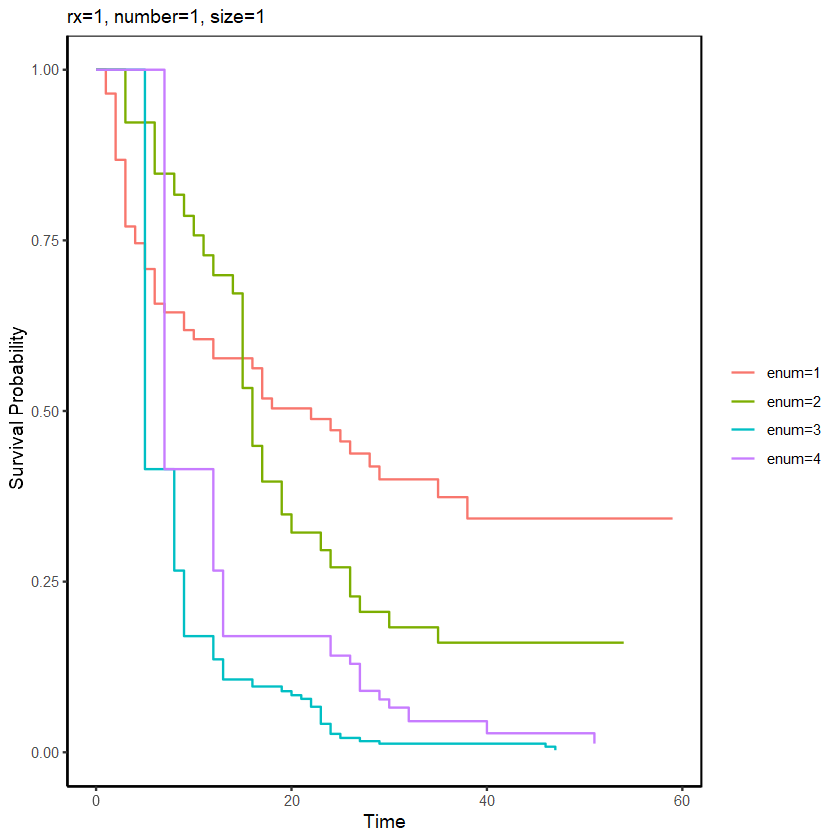

In [57]:
adjustedPlot(fit2, xnames = "enum")

# 
#### 소요시간방법

In [58]:
fit3 = coxph(Surv(start, stop, event) ~ rx + number + size + cluster(id) + strata(enum), 
             bladder2 %>% mutate(stop = stop - start, start= 0))
summary(fit3)

Call:
coxph(formula = Surv(start, stop, event) ~ rx + number + size + 
    strata(enum), data = bladder2 %>% mutate(stop = stop - start, 
    start = 0), cluster = id)

  n= 178, number of events= 112 

            coef exp(coef)  se(coef) robust se      z Pr(>|z|)   
rx     -0.279005  0.756536  0.207348  0.215624 -1.294  0.19569   
number  0.158046  1.171220  0.051942  0.050940  3.103  0.00192 **
size    0.007415  1.007443  0.070023  0.064333  0.115  0.90824   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

       exp(coef) exp(-coef) lower .95 upper .95
rx        0.7565     1.3218    0.4958     1.154
number    1.1712     0.8538    1.0599     1.294
size      1.0074     0.9926    0.8881     1.143

Concordance= 0.596  (se = 0.032 )
Likelihood ratio test= 9.33  on 3 df,   p=0.03
Wald test            = 11.84  on 3 df,   p=0.008
Score (logrank) test = 10.27  on 3 df,   p=0.02,   Robust = 9.92  p=0.02

  (Note: the likelihood ratio and score tests assume independence of

# 
#### 주변방법

In [60]:
fit4 = coxph(Surv(stop, event) ~ rx + number + size + cluster(id) + strata(enum), bladder)
summary(fit4)

Call:
coxph(formula = Surv(stop, event) ~ rx + number + size + strata(enum), 
    data = bladder, cluster = id)

  n= 340, number of events= 112 

           coef exp(coef) se(coef) robust se      z Pr(>|z|)   
rx     -0.58479   0.55722  0.20105   0.30795 -1.899   0.0576 . 
number  0.21029   1.23404  0.04675   0.06664  3.156   0.0016 **
size   -0.05162   0.94969  0.06973   0.09459 -0.546   0.5853   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

       exp(coef) exp(-coef) lower .95 upper .95
rx        0.5572     1.7946    0.3047     1.019
number    1.2340     0.8103    1.0829     1.406
size      0.9497     1.0530    0.7890     1.143

Concordance= 0.663  (se = 0.036 )
Likelihood ratio test= 25.26  on 3 df,   p=1e-05
Wald test            = 15.54  on 3 df,   p=0.001
Score (logrank) test = 28.6  on 3 df,   p=3e-06,   Robust = 11.63  p=0.009

  (Note: the likelihood ratio and score tests assume independence of
     observations within a cluster, the Wald and robust sco

# 
# 
### 10-4 4가지 방법에 의한 분석 정리

In [68]:
result = autoReg(fit1) %>% rename("HR(Counting Process)" = "HR (multivariable)")
final = result %>%
    addFitSummary(fit2, statsname = "HR(Stratified CP)") %>%
    addFitSummary(fit3, statsname = "HR(Gap Time)") %>%
    addFitSummary(fit4, statsname = "HR(Marginal)")
final

name,desc,stats,id,HR(Counting Process),HR(Stratified CP),HR(Gap Time),HR(Marginal)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rx,Mean ± SD,1.4 ± 0.5,rx,"0.63 (0.37-1.06, p=.080)","0.72 (0.48-1.07, p=.103)","0.76 (0.50-1.15, p=.196)","0.56 (0.30-1.02, p=.058)"
number,Mean ± SD,2.3 ± 1.8,number,"1.19 (1.05-1.35, p=.006)","1.13 (1.02-1.25, p=.020)","1.17 (1.06-1.29, p=.002)","1.23 (1.08-1.41, p=.002)"
size,Mean ± SD,2.0 ± 1.4,size,"0.96 (0.82-1.11, p=.574)","0.99 (0.88-1.12, p=.890)","1.01 (0.89-1.14, p=.908)","0.95 (0.79-1.14, p=.585)"


# 
#### 예측변수 rx에 대한 추정된 회귀계수와 표준오차, p-value
- 연구자가 각 대상환자에서 일어난 재발사건을 구별하기 원하지 않는 경우에는 계수과정접근법이 가장 적절한 방법
- **연구자가 재발사건이 일어난 순서에 따라 치료효과를 구별하고자 할 경우, 층화된 콕스방법 3가지 중 하나를 선택**
    - **층화된 계수과정(Stratified CP)방법은 연구의 목적이 연구에 등록된 시간으로부터 각 재발사건까지의 시간인 경우 선호
    - **소요시간 방법(Gap Time)은 연구에 등록된 시간부터 재발사건까지의 시간이 아닌, 바로 전 재발사건으로부터 그 다음 재발사건까지의 시간(0부터 다시 시작)에 관심이 있는 경우 선호**
    - **주변방법(Marginal) 방법은 각 재발사건의 게층을 서로 다른 질환의 상태라고 판단할 때 권장**
    - **(층화된 계수과정 방법과 주변방법의 차이는 매우 미묘 : 각 계층이 확실하게 다른 양상의 재발사건이라고 할 수 없는 경우, 층화된 계수과정 방법을 선호 / 각 계층이 확실히 다른 양상의 사건이라고 할 수 있는 경우 주변방법 권장)**

# 
| Model | coef | SE(NR) | SE(R) | p(NR) | p(R) |
| - | - | - | - | - | - |
| Counting Process | -0.465 | 0.2 | 0.266 | 0.02 | 0.08 |
| Stratified CP | -0.333 |0.216 | 0.205| 0.123|0.103 |
| Gap time | -0.279 | 0.207| 0.216| 0.178| 0.196|
| Marginal | -0.585 |0.201 |0.308 | 0.004| 0.058|